-------------------------------------------------------------------------------------------------------------------------------
# pyAutonomousAgents
-------------------------------------------------------------------------------------------------------------------------------

============================================================
============================================================
# Install py-trees

In [ ]:
!pip install py-trees==2.2.3

============================================================
============================================================
# Install celluloid

In [ ]:
!pip install celluloid==0.2.0

============================================================
============================================================

# Two-dimensional motion of a drone:

- modulus of the velocity (v)

- orientation angle (alfa)

- vehicle's position (p = (x,y))


x(t) = x(t-1) + v(t-1) * seno(alfa(t-1))

y(t) = y(t-1) + v(t-1) * cosseno(alfa(t-1))
 

<div>
<img src="drone.jpg" width="400"/>
</div>

--> Simulation Finished <--  simulation time = 2.1449766159057617  seconds
----------------------------------------------------------------
GRAPHICAL PART
----------------------------------------------------------------
simulation_data[drone1]['positions'].shape = (8000, 2)
simulation_data[drone1]['orientation_angles'].shape = (8000,)
simulation_data[drone1]['energy_levels'].shape = (8000,)
simulation_data[drone1]['velocities'].shape = (8000,)
simulation_data[drone1]['number_ticks'].shape = (8000,)
simulation_data[drone1]['indexes_current_surveillance_positions'].shape = (0,)
simulation_data[drone1]['damage_levels'].shape = (8000,)
simulation_data[drone2]['positions'].shape = (8000, 2)
simulation_data[drone2]['orientation_angles'].shape = (8000,)
simulation_data[drone2]['energy_levels'].shape = (8000,)
simulation_data[drone2]['velocities'].shape = (8000,)
simulation_data[drone2]['number_ticks'].shape = (8000,)
simulation_data[drone2]['indexes_current_surveillance_positions'].shape = (0

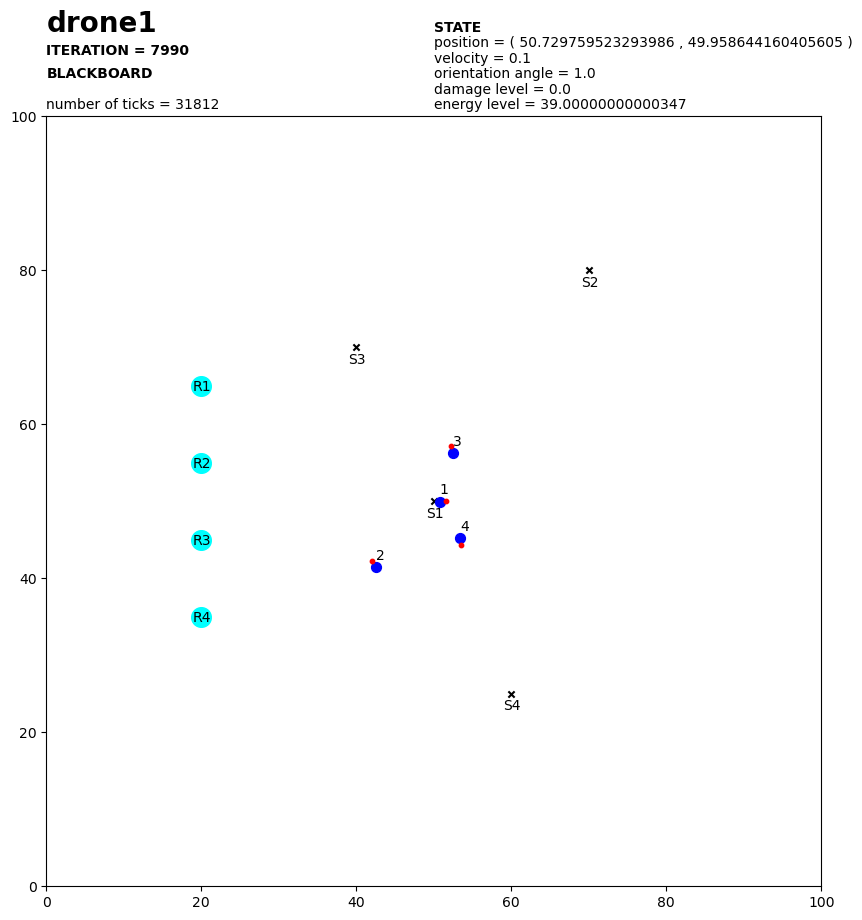

In [1]:
import numpy
import math
import py_trees
from matplotlib import pyplot
import time
from celluloid import Camera


#----------------------------------------------------------------------------------------------------------------------
# Environment parameters.
#----------------------------------------------------------------------------------------------------------------------
environment = {
    # Limiting coordinates of the environment
    # x belongs to the interval [0.0 , 100.0]
    # y belongs to the interval [0.0 , 100.0]
    "limiting coordinates":{
        "min_x":0.0,
        "max_x":100.0,
        "min_y":0.0,
        "max_y":100.0
    },
    # Radiation
    "radiation":{
        "radiation sources":[
            ["source 1",40.0,40.0,10.0] #[source name, x, y, radiation range]
        ],
        "activated_radiation_source":False
    },
    # Surveillance positions
    "surveillance_positions":[[50.0,50.0],[70.0,80.0],[40.0,70.0],[60.0,25.0]],
    # Broadcast channel
    "broadcast":[]
}
#----------------------------------------------------------------------------------------------------------------------


class Energy_Sensor:
    
    def __init__(self, energy_level):
        self.energy_level = energy_level
    
    def Read_Energy_Level(self):
        return self.energy_level
    
    def Updade_Energy_Level(self,energy_consumption):
        self.energy_level = self.energy_level - energy_consumption
        
    def Set_Energy_Level(self, new_energy_level):
        self.energy_level = new_energy_level

        
class Damage_Sensor:
    
    def __init__(self, damage_level):
        self.damage_level = damage_level
    
    def Read_Damage_Level(self):
        return self.damage_level
    
    def Updade_Damage_Level(self,damage_factor,damage_percentage):
        self.damage_level = self.damage_level + damage_factor * damage_percentage
        
    def Set_Damage_Level(self, new_damage_level):
        self.damage_level = new_damage_level
        

class Radiation_Sensor:
    
    def Read_Radiation_Level(self, x, y):        
              
        radiation_level = 0.0
        
        if (environment["radiation"]["activated_radiation_source"] == True):
                    
            for index_radiation_source in range(len(environment["radiation"]["radiation sources"])):
                         
                distance_agent_radiation_source = math.sqrt((x-environment["radiation"]["radiation sources"][index_radiation_source][1])*
                                                            (x-environment["radiation"]["radiation sources"][index_radiation_source][1]) +
                                                            (y-environment["radiation"]["radiation sources"][index_radiation_source][2])*
                                                            (y-environment["radiation"]["radiation sources"][index_radiation_source][2]))
        
                if (distance_agent_radiation_source < environment["radiation"]["radiation sources"][index_radiation_source][3]):
                    # 0.0 < radiation_level_per_source <= 1.0
                    radiation_level_per_source = 1.0 - distance_agent_radiation_source / environment["radiation"]["radiation sources"][index_radiation_source][3]        
                    radiation_level = radiation_level + radiation_level_per_source
        
        return radiation_level


class Datalink:
    
    #----------------------------------------------------------------------------------------------
    # message protocol
    #----------------------------------------------------------------------------------------------
    # message[0] is the sender ID.
    # message[1] is the list of receiver IDs.
    # message[2] is the message type.
    # message[3] is the data, which depends of the message type.
    # message[4] is the position of the sender at the time(iteration) it transmitted this message.
    #----------------------------------------------------------------------------------------------
    
    datalink_range = 1000.0
    
    def __init__(self, agent_ID):
        self.agent_ID = agent_ID
    
    def receive_messages(self,agent_position):
        received_messages = []
        for index_of_message in range(len(environment["broadcast"])):
            message = environment["broadcast"][index_of_message]
            if (message[0] != self.agent_ID):
                if (message[1][0] == "all"):
                    sender_position = message[4]
                    distance_agent_sender = math.sqrt((agent_position[0]-sender_position[0])*(agent_position[0]-sender_position[0]) + (agent_position[1]-sender_position[1])*(agent_position[1]-sender_position[1]))                
                    if (distance_agent_sender <= self.datalink_range):
                        received_messages.append(message)
                else:
                    for index_receiver in range(len(message[1])):
                        if (message[1][index_receiver] == self.agent_ID):
                            sender_position = message[4]
                            distance_agent_sender = math.sqrt((agent_position[0]-sender_position[0])*(agent_position[0]-sender_position[0]) + (agent_position[1]-sender_position[1])*(agent_position[1]-sender_position[1]))                
                            if (distance_agent_sender <= self.datalink_range):
                                received_messages.append(message)
        return received_messages
    
    def transmit_messages(self, transmitted_message):
        environment["broadcast"].append(transmitted_message)


class Drone:
    
    #----------------------------------------------------------------------------------------------------------------------
    # Internal parameters
    #----------------------------------------------------------------------------------------------------------------------
    energy_consumption = 0.05 # % per iteration.
    limit_energy_refueling = 40.0 # %.
    refueling_rate = 2.0 # % per iteration.
    maximum_control_signal_orientation_angle = 1.0 # degrees.
    maximum_control_signal_velocity = 0.1 # units per iteration.
    control_signal_orientation_angle = 0.0 # variation of the orientation angle, in degrees.
    control_signal_velocity = 0.0 # variation of the velocity, in units per iteration.
    factor_radiation_damage = 0.1 # damage per radiation level equal to 100%.
    limit_damage = 70.0 # %.
    repair_rate = 1.0 # damage level deacreased per iteration.
    reference_velocity = 0.1 # units per iteration
    
    # Construtor
    def __init__(self, ID):
        self.ID = ID
        
        self.action = {
            'required_orientation_angle':0.0, # degrees
            'required_velocity': 0.1 # units per iteration
        }
    
        #----------------------------------------------------------------------------------------------------------------------
        # Sensors
        #----------------------------------------------------------------------------------------------------------------------
        self.energy_sensor = Energy_Sensor(100.0)
    
        self.damage_sensor = Damage_Sensor(0.0)
    
        self.radiation_sensor = Radiation_Sensor()
        #----------------------------------------------------------------------------------------------------------------------
    
    
        #----------------------------------------------------------------------------------------------------------------------
        # State of the drone
        #----------------------------------------------------------------------------------------------------------------------
        self.state = {
            'x': 0.0,
            'y': 0.0,
            'velocity': 0.1,
            'orientation_angle': 0.0,
            'energy_level': 100.0,
            'damage_level': 0.0,
            'simulation_time': 0
        }
        #----------------------------------------------------------------------------------------------------------------------
        
        #----------------------------------------------------------------------------------------------------------------------
        # Blackboard
        #----------------------------------------------------------------------------------------------------------------------
        self.blackboard = {
            'number_ticks':0,
            'x_surveillance_position': 70.0,
            'y_surveillance_position': 80.0, 
            'x_refueling_position': 10.0,
            'y_refueling_position': 50.0, 
            'x_current_destination_position': 20.0,
            'y_current_destination_position': 80.0
        }
        #----------------------------------------------------------------------------------------------------------------------
        
        #----------------------------------------------------------------------------------------------------------------------
        # Shared data
        #----------------------------------------------------------------------------------------------------------------------
        self.shared_data = {}
        #----------------------------------------------------------------------------------------------------------------------
        
        #----------------------------------------------------------------------------------------------------------------------
        # Datalink
        #----------------------------------------------------------------------------------------------------------------------
        self.datalink = Datalink(self.ID)
        self.received_messages = []
        #----------------------------------------------------------------------------------------------------------------------
        
        #----------------------------------------------------------------------------------------------------------------------
        # Root of the behavior tree
        #----------------------------------------------------------------------------------------------------------------------
        self.behavior_tree_root = None
        #----------------------------------------------------------------------------------------------------------------------
    
    
    #----------------------------------------------------------------------------------------------------------------------
    def S(self,x1, y1, x2, y2, x3, y3):
    
        s = (y2 - y1) * (x3 - x2) - (y3 - y2) * (x2 - x1)
    
        return s
    #----------------------------------------------------------------------------------------------------------------------
    
    
    #----------------------------------------------------------------------------------------------------------------------
    def Get_Datalink_Data(self):
        self.received_messages = self.datalink.receive_messages([self.state['x'],self.state['y']])
    #----------------------------------------------------------------------------------------------------------------------
    
    
    #----------------------------------------------------------------------------------------------------------------------
    def Get_Sensors_Data(self):
        
        #---------------------------------------------------
        # Get data from radiation sensor.
        radiation_level = self.radiation_sensor.Read_Radiation_Level(self.state['x'],self.state['y'])
        #---------------------------------------------------
        
        #---------------------------------------------------
        # Update and get data from damage sensor. Observation: the drone can suffer damage due to different causes.
        self.damage_sensor.Updade_Damage_Level(self.factor_radiation_damage,radiation_level)
        self.state['damage_level'] =  self.damage_sensor.Read_Damage_Level()
        #---------------------------------------------------
        
        #---------------------------------------------------
        # Update and get data from energy sensor.
        self.energy_sensor.Updade_Energy_Level(self.energy_consumption)
        self.state['energy_level'] =  self.energy_sensor.Read_Energy_Level()
        #---------------------------------------------------        
        
    #----------------------------------------------------------------------------------------------------------------------
    
    
    #----------------------------------------------------------------------------------------------------------------------
    def Update_Motion_Model(self):
                
        # Update the position.
        self.state['x'] = self.state['x'] + self.state['velocity'] * math.cos(self.state['orientation_angle'] * math.pi / 180.0)
        
        self.state['y'] = self.state['y'] + self.state['velocity'] * math.sin(self.state['orientation_angle'] * math.pi / 180.0)
        
        # Update the orientation angle.
        self.state['orientation_angle'] = self.state['orientation_angle'] + self.control_signal_orientation_angle
        
        # Update the velocity.
        if ((self.state['velocity'] == self.maximum_control_signal_velocity) and
            (self.control_signal_velocity == self.maximum_control_signal_velocity)):
            self.control_signal_velocity = 0.0
        self.state['velocity'] = self.state['velocity'] + self.control_signal_velocity
        
        if (self.state['orientation_angle'] < 0.0):
            self.state['orientation_angle'] = 360.0 + self.state['orientation_angle']
        else:
            if (self.state['orientation_angle'] > 360.0):
                self.state['orientation_angle'] = self.state['orientation_angle'] - 360.0
    #----------------------------------------------------------------------------------------------------------------------
    
    
    #----------------------------------------------------------------------------------------------------------------------
    def Process_Received_Messages(self):
        
        #----------------------------------------------------------------------------------------------
        # message protocol
        #----------------------------------------------------------------------------------------------
        # message[0] is the sender ID.
        # message[1] is the list of receiver IDs.
        # message[2] is the message type.
        # message[3] is the data, which depends of the message type.
        # message[4] is the position of the sender at the time(iteration) it transmitted this message.
        #----------------------------------------------------------------------------------------------
        
        for index_message in range(len(self.received_messages)):
            
            if (self.received_messages[index_message][2] == "sharing data"):
                
                self.shared_data[self.received_messages[index_message][0]] = self.received_messages[index_message][3]
            else:
                
                if (self.received_messages[index_message][2] == "gathering"):
                    
                    self.blackboard['x_surveillance_position'] = self.received_messages[index_message][3][0]
                    self.blackboard['y_surveillance_position'] = self.received_messages[index_message][3][1]
    #----------------------------------------------------------------------------------------------------------------------
    
    
    #----------------------------------------------------------------------------------------------------------------------
    def Update_State(self, t):
    
        if (self.state['energy_level'] > 0.0):
            
            self.Get_Sensors_Data()
            
            self.Update_Motion_Model()
            
            self.Process_Received_Messages()
            
            self.state['simulation_time'] = t
        
        else:
            
            print(">>>> PROBLEM: drone without energy <<<<")
    #----------------------------------------------------------------------------------------------------------------------
    
    #----------------------------------------------------------------------------------------------------------------------
    # Systems
    #----------------------------------------------------------------------------------------------------------------------
    def Control_System(self):
        
        # Control signal to stop the drone.
        if (self.action['required_velocity'] == 0.0):
            self.control_signal_velocity = 0.0
            if (self.state['velocity'] > 0.0):
                self.control_signal_velocity = -1.0*self.maximum_control_signal_velocity
        
        # Control signal to specify the drone velocity equal to a reference velocity.
        if (self.action['required_velocity'] == self.reference_velocity):
            self.control_signal_velocity = 0.0
            if (self.state['velocity'] < self.reference_velocity):
                self.control_signal_velocity = 1.0*self.maximum_control_signal_velocity
            if (self.state['velocity'] > self.reference_velocity):
                self.control_signal_velocity = -1.0*self.maximum_control_signal_velocity
        
        # Control signal to specify the drone orientation angle.
        difference1 = abs(self.action['required_orientation_angle'] - self.state['orientation_angle']) 
        difference2 = abs(360.0 - self.action['required_orientation_angle'] + self.state['orientation_angle'])
        difference3 = abs(360.0 - self.state['orientation_angle'] + self.action['required_orientation_angle'])
        if (self.state['orientation_angle'] < self.action['required_orientation_angle']):
            if (difference1 < difference2):
                # Turn left
                self.control_signal_orientation_angle = self.maximum_control_signal_orientation_angle
            else: # (difference1 >= difference2)
                # Turn right
                self.control_signal_orientation_angle = -1.0*self.maximum_control_signal_orientation_angle
        else:
            if (self.state['orientation_angle'] > self.action['required_orientation_angle']):
                if (difference1 < difference3):
                    # Turn right
                    self.control_signal_orientation_angle = -1.0*self.maximum_control_signal_orientation_angle
                else: # (difference1 >= difference3):
                    # Turn left
                    self.control_signal_orientation_angle = self.maximum_control_signal_orientation_angle
            else:
                if (self.state['orientation_angle'] == self.action['required_orientation_angle']):
                    self.control_signal_orientation_angle = 0.0
    #----------------------------------------------------------------------------------------------------------------------
    
    
    #----------------------------------------------------------------------------------------------------------------------
    # Behavior tree of the drone
    #----------------------------------------------------------------------------------------------------------------------
    
    # Definition of the classes of the behavior tree nodes.
    # Each class is the type of a condiction or action node.
    
    #++++++++
    class Condition_Destination_Reached(py_trees.behaviour.Behaviour):
        
        def __init__(self, autonomous_agent, name: str = "Condition_Destination_Reached"):
            self.autonomous_agent = autonomous_agent
            #Configure the name of the behaviour.
            super(self.autonomous_agent.Condition_Destination_Reached, self).__init__(name)
            self.logger.debug("%s.__init__()" % (self.__class__.__name__))

        def setup(self, **kwargs: int) -> None:
            #No delayed initialisation required for this example.
            self.logger.debug("%s.setup()" % (self.__class__.__name__))

        def initialise(self) -> None:
            #Reset a counter variable.
            self.logger.debug("%s.initialise()" % (self.__class__.__name__))

        def update(self) -> py_trees.common.Status:
            new_status = (py_trees.common.Status.FAILURE)
        
            self.autonomous_agent.blackboard['number_ticks'] = self.autonomous_agent.blackboard['number_ticks'] + 1
    
            #print("tick on the node Condition_Destination_Reached")
        
            ##########
            distance_limit = 0.5
            
            distance_agent_destination = math.sqrt((self.autonomous_agent.state['x']-self.autonomous_agent.blackboard['x_current_destination_position'])*
                                                  (self.autonomous_agent.state['x']-self.autonomous_agent.blackboard['x_current_destination_position']) +
                                                  (self.autonomous_agent.state['y']-self.autonomous_agent.blackboard['y_current_destination_position'])*
                                                  (self.autonomous_agent.state['y']-self.autonomous_agent.blackboard['y_current_destination_position']))
            
            if (distance_agent_destination <= distance_limit):
                new_status = (py_trees.common.Status.SUCCESS)
            ##########
        
            #print("    status =",new_status)
            return new_status

        def terminate(self, new_status: py_trees.common.Status) -> None:
            #Nothing to clean up in this example.
            self.logger.debug(
                "%s.terminate()[%s->%s]"
                % (self.__class__.__name__, self.status, new_status)
            )
    
    #++++++++
    
    #++++++++
    class Action_Navigate_To_Destination_A(py_trees.behaviour.Behaviour):
        
        def __init__(self, autonomous_agent, name: str = "Action_Navigate_To_Destination_A"):
            self.autonomous_agent = autonomous_agent
            #Configure the name of the behaviour.
            super(self.autonomous_agent.Action_Navigate_To_Destination_A, self).__init__(name)
            self.logger.debug("%s.__init__()" % (self.__class__.__name__))

        def setup(self, **kwargs: int) -> None:
            #No delayed initialisation required for this example.
            self.logger.debug("%s.setup()" % (self.__class__.__name__))

        def initialise(self) -> None:
            #Reset a counter variable.
            self.logger.debug("%s.initialise()" % (self.__class__.__name__))

        def update(self) -> py_trees.common.Status:
            new_status = (py_trees.common.Status.FAILURE)
        
            self.autonomous_agent.blackboard['number_ticks'] = self.autonomous_agent.blackboard['number_ticks'] + 1
    
            #print("tick on the node Action_Navigate_To_Destination_A")
        
            ##########
            # Velocity is specified equal to the reference velocity aiming to avoid velocity changing.
            self.autonomous_agent.action['required_velocity'] = self.autonomous_agent.reference_velocity
        
            # Calculate the auxiliary future position.
            x_future_position = self.autonomous_agent.state['x'] + math.cos(self.autonomous_agent.state['orientation_angle']*math.pi/180.0)
            y_future_position = self.autonomous_agent.state['y'] + math.sin(self.autonomous_agent.state['orientation_angle']*math.pi/180.0)
    
            # u1 is the unit vector based on the vector (agent's position, future position)
            x_u1 = x_future_position - self.autonomous_agent.state['x']
            y_u1 = y_future_position - self.autonomous_agent.state['y']
            
            # u2 is the unit vector based on the vector (agent's position, destination)
            x_u2 = self.autonomous_agent.blackboard['x_current_destination_position'] - self.autonomous_agent.state['x']
            y_u2 = self.autonomous_agent.blackboard['y_current_destination_position'] - self.autonomous_agent.state['y']
            
            # Angle alfa between the unit vectors u1 and u2.
            alfa = math.acos( (x_u1*x_u2 + y_u1*y_u2) / (math.sqrt(x_u1*x_u1 + y_u1*y_u1) * math.sqrt(x_u2*x_u2 + y_u2*y_u2)) )        
            
            alfa = alfa*180.0/math.pi
        
            # Side of the destination position relative to the navigation direction of the drone (heading).
            s = self.autonomous_agent.S(self.autonomous_agent.state['x'],
                                        self.autonomous_agent.state['y'],
                                        x_future_position,
                                        y_future_position,
                                        self.autonomous_agent.blackboard['x_current_destination_position'],
                                        self.autonomous_agent.blackboard['y_current_destination_position'])
    
            self.autonomous_agent.action['required_orientation_angle'] = self.autonomous_agent.state['orientation_angle']
            
            if (s < 0.0): # counterclockwise
                # Turn left
                self.autonomous_agent.action['required_orientation_angle'] = self.autonomous_agent.state['orientation_angle'] + alfa
            else:
                if (s > 0): # clockwise
                    # Turn right
                    self.autonomous_agent.action['required_orientation_angle'] = self.autonomous_agent.state['orientation_angle'] - alfa
                else:
                    if (s == 0.0):
                        self.autonomous_agent.action['required_orientation_angle'] = self.autonomous_agent.state['orientation_angle']
            
            if (self.autonomous_agent.action['required_orientation_angle'] < 0.0):
                self.autonomous_agent.action['required_orientation_angle'] = self.autonomous_agent.action['required_orientation_angle'] + 360.0
            if (self.autonomous_agent.action['required_orientation_angle'] > 360.0):
                self.autonomous_agent.action['required_orientation_angle'] = self.autonomous_agent.action['required_orientation_angle'] - 360.0
            
            new_status = (py_trees.common.Status.RUNNING)
            ##########
        
            #print("    status =",new_status)
            return new_status

        def terminate(self, new_status: py_trees.common.Status) -> None:
            #Nothing to clean up in this example.
            self.logger.debug(
                "%s.terminate()[%s->%s]"
                % (self.__class__.__name__, self.status, new_status)
            )
    
    #++++++++
    class Condition_Low_Energy_Level(py_trees.behaviour.Behaviour):
        
        def __init__(self, autonomous_agent, name: str = "Condition_Low_Energy_Level"):
            self.autonomous_agent = autonomous_agent
            #Configure the name of the behaviour.
            super(self.autonomous_agent.Condition_Low_Energy_Level, self).__init__(name)
            self.logger.debug("%s.__init__()" % (self.__class__.__name__))

        def setup(self, **kwargs: int) -> None:
            #No delayed initialisation required for this example.
            self.logger.debug("%s.setup()" % (self.__class__.__name__))

        def initialise(self) -> None:
            #Reset a counter variable.
            self.logger.debug("%s.initialise()" % (self.__class__.__name__))

        def update(self) -> py_trees.common.Status:
            new_status = (py_trees.common.Status.FAILURE)
        
            self.autonomous_agent.blackboard['number_ticks'] = self.autonomous_agent.blackboard['number_ticks'] + 1
    
            #print("tick on the node Condition_Low_Energy_Level")
        
            ##########
            if (self.autonomous_agent.state['energy_level'] <= self.autonomous_agent.limit_energy_refueling):
                new_status = (py_trees.common.Status.SUCCESS)
            ##########
        
            #print("    status =",new_status)
            return new_status

        def terminate(self, new_status: py_trees.common.Status) -> None:
            #Nothing to clean up in this example.
            self.logger.debug(
                "%s.terminate()[%s->%s]"
                % (self.__class__.__name__, self.status, new_status)
            )
    
    #++++++++
    class Action_Set_Destination_Equal_To_Refueling_Position_S(py_trees.behaviour.Behaviour):
        
        def __init__(self, autonomous_agent, name: str = "Action_Set_Destination_Equal_To_Refueling_Position_S"):
            self.autonomous_agent = autonomous_agent
            #Configure the name of the behaviour.
            super(self.autonomous_agent.Action_Set_Destination_Equal_To_Refueling_Position_S, self).__init__(name)
            self.logger.debug("%s.__init__()" % (self.__class__.__name__))

        def setup(self, **kwargs: int) -> None:
            #No delayed initialisation required for this example.
            self.logger.debug("%s.setup()" % (self.__class__.__name__))

        def initialise(self) -> None:
            #Reset a counter variable.
            self.logger.debug("%s.initialise()" % (self.__class__.__name__))

        def update(self) -> py_trees.common.Status:
            new_status = (py_trees.common.Status.FAILURE)
        
            self.autonomous_agent.blackboard['number_ticks'] = self.autonomous_agent.blackboard['number_ticks'] + 1
    
            #print("tick on the node Action_Set_Destination_Equal_To_Refueling_Position_S")
        
            ##########
            self.autonomous_agent.blackboard['x_current_destination_position'] = self.autonomous_agent.blackboard['x_refueling_position']
            self.autonomous_agent.blackboard['y_current_destination_position'] = self.autonomous_agent.blackboard['y_refueling_position']
            
            new_status = (py_trees.common.Status.SUCCESS)
            ##########
            
            #print("    status =",new_status)
            return new_status

        def terminate(self, new_status: py_trees.common.Status) -> None:
            #Nothing to clean up in this example.
            self.logger.debug(
                "%s.terminate()[%s->%s]"
                % (self.__class__.__name__, self.status, new_status)
            )
    
    #++++++++
    class Action_Set_Destination_Equal_To_Surveillance_Position_S(py_trees.behaviour.Behaviour):
        
        def __init__(self, autonomous_agent, name: str = "Action_Set_Destination_Equal_To_Surveillance_Position_S"):
            self.autonomous_agent = autonomous_agent
            #Configure the name of the behaviour.
            super(self.autonomous_agent.Action_Set_Destination_Equal_To_Surveillance_Position_S, self).__init__(name)
            self.logger.debug("%s.__init__()" % (self.__class__.__name__))

        def setup(self, **kwargs: int) -> None:
            #No delayed initialisation required for this example.
            self.logger.debug("%s.setup()" % (self.__class__.__name__))

        def initialise(self) -> None:
            #Reset a counter variable.
            self.logger.debug("%s.initialise()" % (self.__class__.__name__))

        def update(self) -> py_trees.common.Status:
            new_status = (py_trees.common.Status.FAILURE)
        
            self.autonomous_agent.blackboard['number_ticks'] = self.autonomous_agent.blackboard['number_ticks'] + 1
    
            #print("tick on the node Action_Set_Destination_Equal_To_Surveillance_Position_S")
        
            ##########
            self.autonomous_agent.blackboard['x_current_destination_position'] = self.autonomous_agent.blackboard['x_surveillance_position']
            self.autonomous_agent.blackboard['y_current_destination_position'] = self.autonomous_agent.blackboard['y_surveillance_position']
            
            new_status = (py_trees.common.Status.SUCCESS)
            ##########
            
            #print("    status =",new_status)
            return new_status

        def terminate(self, new_status: py_trees.common.Status) -> None:
            #Nothing to clean up in this example.
            self.logger.debug(
                "%s.terminate()[%s->%s]"
                % (self.__class__.__name__, self.status, new_status)
            )
            
    #++++++++
    class Action_Refuel_A(py_trees.behaviour.Behaviour):
        
        def __init__(self, autonomous_agent, name: str = "Action_Refuel_A"):
            self.autonomous_agent = autonomous_agent
            #Configure the name of the behaviour.
            super(self.autonomous_agent.Action_Refuel_A, self).__init__(name)
            self.logger.debug("%s.__init__()" % (self.__class__.__name__))

        def setup(self, **kwargs: int) -> None:
            #No delayed initialisation required for this example.
            self.logger.debug("%s.setup()" % (self.__class__.__name__))

        def initialise(self) -> None:
            #Reset a counter variable.
            self.logger.debug("%s.initialise()" % (self.__class__.__name__))

        def update(self) -> py_trees.common.Status:
            new_status = (py_trees.common.Status.FAILURE)
        
            self.autonomous_agent.blackboard['number_ticks'] = self.autonomous_agent.blackboard['number_ticks'] + 1
    
            #print("tick on the node Action_Refuel_A")
        
            ##########
            # Required velocity is specified equal to zero to stop the drone motion.
            self.autonomous_agent.action['required_velocity'] = 0.0
            
            # Required orientation angle is specified equal to the current orientation angle.            
            self.autonomous_agent.action['required_orientation_angle'] = self.autonomous_agent.state['orientation_angle']
            
            new_status = (py_trees.common.Status.RUNNING)
            
            self.autonomous_agent.energy_sensor.Set_Energy_Level(self.autonomous_agent.energy_sensor.Read_Energy_Level() + self.autonomous_agent.refueling_rate)
            
            if (self.autonomous_agent.energy_sensor.Read_Energy_Level() > 100.0):
                self.autonomous_agent.energy_sensor.Set_Energy_Level(100.0)
            
            if (self.autonomous_agent.energy_sensor.Read_Energy_Level() == 100.0):
                # Control signal to restart the drone motion with the reference velocity.
                self.autonomous_agent.action['required_velocity'] = self.autonomous_agent.reference_velocity
                new_status = (py_trees.common.Status.SUCCESS)
            ##########
        
            #print("    status =",new_status)
            return new_status

        def terminate(self, new_status: py_trees.common.Status) -> None:
            #Nothing to clean up in this example.
            self.logger.debug(
                "%s.terminate()[%s->%s]"
                % (self.__class__.__name__, self.status, new_status)
            )
    
    #++++++++
    class Condition_Radiation_Detected(py_trees.behaviour.Behaviour):
        
        def __init__(self, autonomous_agent, name: str = "Condition_Radiation_Detected"):
            self.autonomous_agent = autonomous_agent
            #Configure the name of the behaviour.
            super(self.autonomous_agent.Condition_Radiation_Detected, self).__init__(name)
            self.logger.debug("%s.__init__()" % (self.__class__.__name__))

        def setup(self, **kwargs: int) -> None:
            #No delayed initialisation required for this example.
            self.logger.debug("%s.setup()" % (self.__class__.__name__))

        def initialise(self) -> None:
            #Reset a counter variable.
            self.logger.debug("%s.initialise()" % (self.__class__.__name__))

        def update(self) -> py_trees.common.Status:
            new_status = (py_trees.common.Status.FAILURE)
        
            self.autonomous_agent.blackboard['number_ticks'] = self.autonomous_agent.blackboard['number_ticks'] + 1
    
            #print("tick on the node Condition_Radiation_Detected")
        
            ##########
            if (self.autonomous_agent.radiation_sensor.Read_Radiation_Level(self.autonomous_agent.state['x'], self.autonomous_agent.state['y']) > 0.0):
                new_status = (py_trees.common.Status.SUCCESS)
            ##########
        
            #print("    status =",new_status)
            return new_status

        def terminate(self, new_status: py_trees.common.Status) -> None:
            #Nothing to clean up in this example.
            self.logger.debug(
                "%s.terminate()[%s->%s]"
                % (self.__class__.__name__, self.status, new_status)
            )
    
    #++++++++
    class Condition_High_Damage_Level(py_trees.behaviour.Behaviour):
        
        def __init__(self, autonomous_agent, name: str = "Condition_High_Damage_Level"):
            self.autonomous_agent = autonomous_agent
            #Configure the name of the behaviour.
            super(self.autonomous_agent.Condition_High_Damage_Level, self).__init__(name)
            self.logger.debug("%s.__init__()" % (self.__class__.__name__))

        def setup(self, **kwargs: int) -> None:
            #No delayed initialisation required for this example.
            self.logger.debug("%s.setup()" % (self.__class__.__name__))

        def initialise(self) -> None:
            #Reset a counter variable.
            self.logger.debug("%s.initialise()" % (self.__class__.__name__))

        def update(self) -> py_trees.common.Status:
            new_status = (py_trees.common.Status.FAILURE)
        
            self.autonomous_agent.blackboard['number_ticks'] = self.autonomous_agent.blackboard['number_ticks'] + 1
    
            #print("tick on the node Condition_High_Damage_Level")
        
            ##########
            if (self.autonomous_agent.state['damage_level'] >= self.autonomous_agent.limit_damage):
                new_status = (py_trees.common.Status.SUCCESS)
            ##########
        
            #print("    status =",new_status)
            return new_status

        def terminate(self, new_status: py_trees.common.Status) -> None:
            #Nothing to clean up in this example.
            self.logger.debug(
                "%s.terminate()[%s->%s]"
                % (self.__class__.__name__, self.status, new_status)
            )
    
    #++++++++
    class Action_Repair_Damage_A(py_trees.behaviour.Behaviour):
        
        def __init__(self, autonomous_agent, name: str = "Action_Repair_Damage_A"):
            self.autonomous_agent = autonomous_agent
            #Configure the name of the behaviour.
            super(self.autonomous_agent.Action_Repair_Damage_A, self).__init__(name)
            self.logger.debug("%s.__init__()" % (self.__class__.__name__))

        def setup(self, **kwargs: int) -> None:
            #No delayed initialisation required for this example.
            self.logger.debug("%s.setup()" % (self.__class__.__name__))

        def initialise(self) -> None:
            #Reset a counter variable.
            self.logger.debug("%s.initialise()" % (self.__class__.__name__))

        def update(self) -> py_trees.common.Status:
            new_status = (py_trees.common.Status.FAILURE)
        
            self.autonomous_agent.blackboard['number_ticks'] = self.autonomous_agent.blackboard['number_ticks'] + 1
    
            #print("tick on the node Action_Repair_Damage_A")
        
            ##########
            # Required velocity is specified equal to zero to stop the drone motion.
            self.autonomous_agent.action['required_velocity'] = 0.0
            
            # Required orientation angle is specified equal to the current orientation angle.            
            self.autonomous_agent.action['required_orientation_angle'] = self.autonomous_agent.state['orientation_angle']
            
            new_status = (py_trees.common.Status.RUNNING)
            
            self.autonomous_agent.damage_sensor.Set_Damage_Level(self.autonomous_agent.damage_sensor.Read_Damage_Level() - self.autonomous_agent.repair_rate)
            
            if (self.autonomous_agent.damage_sensor.Read_Damage_Level() < 0.0):
                self.autonomous_agent.damage_sensor.Set_Damage_Level(0.0) 
            
            if (self.autonomous_agent.damage_sensor.Read_Damage_Level() == 0.0):
                # Control signal to restart the drone motion with the reference velocity.
                self.autonomous_agent.action['required_velocity'] = self.autonomous_agent.reference_velocity
                new_status = (py_trees.common.Status.SUCCESS)
            ##########
        
            #print("    status =",new_status)
            return new_status

        def terminate(self, new_status: py_trees.common.Status) -> None:
            #Nothing to clean up in this example.
            self.logger.debug(
                "%s.terminate()[%s->%s]"
                % (self.__class__.__name__, self.status, new_status)
            )
    
    #++++++++
    class Action_Transmit_Shared_Data_S(py_trees.behaviour.Behaviour):
        
        def __init__(self, autonomous_agent, name: str = "Action_Transmit_Shared_Data_S"):
            self.autonomous_agent = autonomous_agent
            #Configure the name of the behaviour.
            super(self.autonomous_agent.Action_Transmit_Shared_Data_S, self).__init__(name)
            self.logger.debug("%s.__init__()" % (self.__class__.__name__))

        def setup(self, **kwargs: int) -> None:
            #No delayed initialisation required for this example.
            self.logger.debug("%s.setup()" % (self.__class__.__name__))

        def initialise(self) -> None:
            #Reset a counter variable.
            self.logger.debug("%s.initialise()" % (self.__class__.__name__))

        def update(self) -> py_trees.common.Status:
            new_status = (py_trees.common.Status.FAILURE)
        
            self.autonomous_agent.blackboard['number_ticks'] = self.autonomous_agent.blackboard['number_ticks'] + 1
    
            #print("tick on the node Action_Transmit_Shared_Data_S")
        
            ##########
            #----------------------------------------------------------------------------------------------
            # message protocol
            #----------------------------------------------------------------------------------------------
            # message[0] is the sender ID.
            # message[1] is the receiver ID.
            # message[2] is the message type.
            # message[3] is the data, which depends of the message type.
            # message[4] is the position of the sender at the time(iteration) it transmitted this message.
            #----------------------------------------------------------------------------------------------
            message_data = {
                "x":self.autonomous_agent.state['x'],
                "y":self.autonomous_agent.state['y'],
                "velocity":self.autonomous_agent.state['velocity'],
                "orientation_angle":self.autonomous_agent.state['orientation_angle'],
                "damage_level":self.autonomous_agent.state['damage_level'],
                "energy_level":self.autonomous_agent.state['energy_level']      
            }
            message = [self.autonomous_agent.ID,["all"],"sharing data",message_data,[self.autonomous_agent.state['x'],self.autonomous_agent.state['y']]]
            self.autonomous_agent.datalink.transmit_messages(message)
            
            new_status = (py_trees.common.Status.SUCCESS)
            ##########
        
            #print("    status =",new_status)
            return new_status

        def terminate(self, new_status: py_trees.common.Status) -> None:
            #Nothing to clean up in this example.
            self.logger.debug(
                "%s.terminate()[%s->%s]"
                % (self.__class__.__name__, self.status, new_status)
            )
    
    #++++++++ 
    class Action_Transmit_Gathering_Message_S(py_trees.behaviour.Behaviour):
        
        def __init__(self, autonomous_agent, name: str = "Action_Transmit_Gathering_Message_S"):
            self.autonomous_agent = autonomous_agent
            #Configure the name of the behaviour.
            super(self.autonomous_agent.Action_Transmit_Gathering_Message_S, self).__init__(name)
            self.logger.debug("%s.__init__()" % (self.__class__.__name__))

        def setup(self, **kwargs: int) -> None:
            #No delayed initialisation required for this example.
            self.logger.debug("%s.setup()" % (self.__class__.__name__))

        def initialise(self) -> None:
            #Reset a counter variable.
            self.logger.debug("%s.initialise()" % (self.__class__.__name__))

        def update(self) -> py_trees.common.Status:
            new_status = (py_trees.common.Status.FAILURE)
        
            self.autonomous_agent.blackboard['number_ticks'] = self.autonomous_agent.blackboard['number_ticks'] + 1
    
            #print("tick on the node Action_Transmit_Gathering_Message_S")
        
            ##########
            #----------------------------------------------------------------------------------------------
            # message protocol
            #----------------------------------------------------------------------------------------------
            # message[0] is the sender ID.
            # message[1] is the receiver ID.
            # message[2] is the message type.
            # message[3] is the data, which depends of the message type.
            # message[4] is the position of the sender at the time(iteration) it transmitted this message.
            #----------------------------------------------------------------------------------------------
            message_data = [self.autonomous_agent.blackboard['x_surveillance_position'],self.autonomous_agent.blackboard['y_surveillance_position']]
            message = [self.autonomous_agent.ID,["all"],"gathering",message_data,[self.autonomous_agent.state['x'],self.autonomous_agent.state['y']]]
            self.autonomous_agent.datalink.transmit_messages(message)
            
            new_status = (py_trees.common.Status.SUCCESS)
            ##########
        
            #print("    status =",new_status)
            return new_status

        def terminate(self, new_status: py_trees.common.Status) -> None:
            #Nothing to clean up in this example.
            self.logger.debug(
                "%s.terminate()[%s->%s]"
                % (self.__class__.__name__, self.status, new_status)
            )
    
    #++++++++
    class Condition_Gathering_Moment(py_trees.behaviour.Behaviour):
        
        def __init__(self, autonomous_agent, name: str = "Condition_Gathering_Moment"):
            self.autonomous_agent = autonomous_agent
            #Configure the name of the behaviour.
            super(self.autonomous_agent.Condition_Gathering_Moment, self).__init__(name)
            self.logger.debug("%s.__init__()" % (self.__class__.__name__))

        def setup(self, **kwargs: int) -> None:
            #No delayed initialisation required for this example.
            self.logger.debug("%s.setup()" % (self.__class__.__name__))

        def initialise(self) -> None:
            #Reset a counter variable.
            self.logger.debug("%s.initialise()" % (self.__class__.__name__))

        def update(self) -> py_trees.common.Status:
            new_status = (py_trees.common.Status.FAILURE)
        
            self.autonomous_agent.blackboard['number_ticks'] = self.autonomous_agent.blackboard['number_ticks'] + 1
    
            #print("tick on the node Condition_Gathering_Moment")
        
            ##########
            if ((self.autonomous_agent.state['simulation_time'] == 5000) and (self.autonomous_agent.ID == "drone1")):
                new_status = (py_trees.common.Status.SUCCESS)
            ##########
        
            #print("    status =",new_status)
            return new_status

        def terminate(self, new_status: py_trees.common.Status) -> None:
            #Nothing to clean up in this example.
            self.logger.debug(
                "%s.terminate()[%s->%s]"
                % (self.__class__.__name__, self.status, new_status)
            )
    
    #++++++++     
    #----------------------------------------------------------------------------------------------------------------------
    
    
    #----------------------------------------------------------------------------------------------------------------------
    def Construct_Behavior_Tree(self):
        ##########
        # Creation of the nodes/objects. 
        # Each object is an instance of the respective class.        
        condition_destination_reached = self.Condition_Destination_Reached(self, "condition_destination_reached")
        condition_destination_reached.setup()
        
        action_navigate_to_destination_a_1 = self.Action_Navigate_To_Destination_A(self, "action_navigate_to_destination_a_1")
        action_navigate_to_destination_a_1.setup()
        
        action_navigate_to_destination_a_2 = self.Action_Navigate_To_Destination_A(self, "action_navigate_to_destination_a_2")
        action_navigate_to_destination_a_2.setup()
        
        condition_low_energy_level = self.Condition_Low_Energy_Level(self, "condition_low_energy_level")
        condition_low_energy_level.setup()
        
        action_set_destination_equal_to_refueling_position_s = self.Action_Set_Destination_Equal_To_Refueling_Position_S(self, "action_set_destination_equal_to_refueling_position_s")
        action_set_destination_equal_to_refueling_position_s.setup()
        
        action_set_destination_equal_to_surveillance_position_s = self.Action_Set_Destination_Equal_To_Surveillance_Position_S(self, "action_set_destination_equal_to_surveillance_position_s")
        action_set_destination_equal_to_surveillance_position_s.setup()
        
        action_refuel_a = self.Action_Refuel_A(self, "action_refuel_a")
        action_refuel_a.setup()
        
        action_transmit_shared_data_s = self.Action_Transmit_Shared_Data_S(self,"action_transmit_shared_data_s")
        action_transmit_shared_data_s.setup()
        
        condition_gathering_moment = self.Condition_Gathering_Moment(self,"condition_gathering_moment")
        condition_gathering_moment.setup()
        
        action_transmit_gathering_message_s = self.Action_Transmit_Gathering_Message_S(self,"action_transmit_gathering_message_s")
        action_transmit_gathering_message_s.setup()
        ##########

        ##########
        # Construction of the behavior tree through the created objects. 
        # Observation: the root node is the first node of the behavior tree.
        root = py_trees.composites.Sequence(name="Sequence", memory=False)
        
        reactive_sequence1 = py_trees.composites.Sequence(name="Sequence", memory=False)
        name="Inverter"
        inverter = py_trees.decorators.Inverter(name, condition_destination_reached)
        reactive_sequence1.add_child(inverter)
        reactive_sequence1.add_child(action_navigate_to_destination_a_1)
        
        sequence2 = py_trees.composites.Sequence(name="Sequence", memory=True)
        sequence2.add_child(action_refuel_a)
        sequence2.add_child(action_set_destination_equal_to_surveillance_position_s)
        
        fallback1 = py_trees.composites.Selector(name="Selector", memory=True)
        fallback1.add_child(reactive_sequence1)
        fallback1.add_child(sequence2)
        
        sequence1 = py_trees.composites.Sequence(name="Sequence", memory=True)
        sequence1.add_child(condition_low_energy_level)
        sequence1.add_child(action_set_destination_equal_to_refueling_position_s)
        sequence1.add_child(fallback1)
        
        sequence3 = py_trees.composites.Sequence(name="Sequence", memory=True)
        sequence3.add_child(condition_gathering_moment)
        sequence3.add_child(action_transmit_gathering_message_s)
        
        reactive_fallback1 = py_trees.composites.Selector(name="Selector", memory=False)
        reactive_fallback1.add_child(sequence3)        
        reactive_fallback1.add_child(sequence1)
        reactive_fallback1.add_child(action_navigate_to_destination_a_2)      

        root.add_child(action_transmit_shared_data_s)
        
        root.add_child(reactive_fallback1)
          
        ##########
        
        self.behavior_tree_root = root
    #----------------------------------------------------------------------------------------------------------------------
    
    
    #----------------------------------------------------------------------------------------------------------------------
    def Decision_Making(self):
    
        self.behavior_tree_root.tick_once()
    #----------------------------------------------------------------------------------------------------------------------



        
#----------------------------------------------------------------------------------------------------------------------
# Auxiliary methods for the simulation.
#----------------------------------------------------------------------------------------------------------------------
def Store_Simulation_Data():
    global simulation_data
    global number_autonomous_agents
    global list_autonomous_agents
    
    for index_autonomous_agent in range(number_autonomous_agents):
        
        autonomous_agent = list_autonomous_agents[index_autonomous_agent]

        simulation_data[autonomous_agent.ID]['positions'].append([autonomous_agent.state['x'],autonomous_agent.state['y']])
        simulation_data[autonomous_agent.ID]['orientation_angles'].append(autonomous_agent.state['orientation_angle'])
        simulation_data[autonomous_agent.ID]['energy_levels'].append(autonomous_agent.state['energy_level'])
        simulation_data[autonomous_agent.ID]['velocities'].append(autonomous_agent.state['velocity'])
        simulation_data[autonomous_agent.ID]['number_ticks'].append(autonomous_agent.blackboard['number_ticks'])        
        simulation_data[autonomous_agent.ID]['damage_levels'].append(autonomous_agent.state['damage_level'])

    
def Show_Current_State(autonomous_agent):
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>  t =", t)
    print("----------")
    print("CURRENT STATE")
    print("==> x =", autonomous_agent.state['x'])
    print("==> y =", autonomous_agent.state['y'])
    print("==> orientation angle =", autonomous_agent.state['orientation_angle'])
    print("==> velocity =", autonomous_agent.state['velocity'])
    print("==> energy level =", autonomous_agent.state['energy_level'])
    print("==> damage level =", autonomous_agent.state['damage_level'])
    print("==> number of ticks =", autonomous_agent.blackboard['number_ticks'])
    distance_agent_destination = math.sqrt(
        (autonomous_agent.state['x']-autonomous_agent.blackboard['x_current_destination_position'])*
        (autonomous_agent.state['x']-autonomous_agent.blackboard['x_current_destination_position']) +
        (autonomous_agent.state['y']-autonomous_agent.blackboard['y_current_destination_position'])*
        (autonomous_agent.state['y']-autonomous_agent.blackboard['y_current_destination_position']))
    print("==> distance between the agent and the destination =", distance_agent_destination)
    print("----------\n")

    
def Graphical_Part():
    global simulation_data
    global number_autonomous_agents
    global list_autonomous_agents
    
    print("----------------------------------------------------------------")
    print("GRAPHICAL PART")
    print("----------------------------------------------------------------")
    
    for index_autonomous_agent in range(number_autonomous_agents):   
        
        ID_autonomous_agent = list_autonomous_agents[index_autonomous_agent].ID
    
        simulation_data[ID_autonomous_agent]['positions'] = numpy.array(simulation_data[ID_autonomous_agent]['positions'])
        simulation_data[ID_autonomous_agent]['orientation_angles'] = numpy.array(simulation_data[ID_autonomous_agent]['orientation_angles'])
        simulation_data[ID_autonomous_agent]['energy_levels'] = numpy.array(simulation_data[ID_autonomous_agent]['energy_levels'])
        simulation_data[ID_autonomous_agent]['velocities'] = numpy.array(simulation_data[ID_autonomous_agent]['velocities'])
        simulation_data[ID_autonomous_agent]['number_ticks'] = numpy.array(simulation_data[ID_autonomous_agent]['number_ticks'])
        simulation_data[ID_autonomous_agent]['indexes_current_surveillance_positions'] = numpy.array(simulation_data[ID_autonomous_agent]['indexes_current_surveillance_positions'])
        simulation_data[ID_autonomous_agent]['damage_levels'] = numpy.array(simulation_data[ID_autonomous_agent]['damage_levels'])
        
        print("simulation_data["+ID_autonomous_agent+"]['positions'].shape =",simulation_data[ID_autonomous_agent]['positions'].shape)
        print("simulation_data["+ID_autonomous_agent+"]['orientation_angles'].shape =",simulation_data[ID_autonomous_agent]['orientation_angles'].shape)
        print("simulation_data["+ID_autonomous_agent+"]['energy_levels'].shape =",simulation_data[ID_autonomous_agent]['energy_levels'].shape)
        print("simulation_data["+ID_autonomous_agent+"]['velocities'].shape =",simulation_data[ID_autonomous_agent]['velocities'].shape)
        print("simulation_data["+ID_autonomous_agent+"]['number_ticks'].shape =", simulation_data[ID_autonomous_agent]['number_ticks'].shape)
        print("simulation_data["+ID_autonomous_agent+"]['indexes_current_surveillance_positions'].shape =", simulation_data[ID_autonomous_agent]['indexes_current_surveillance_positions'].shape)
        print("simulation_data["+ID_autonomous_agent+"]['damage_levels'].shape =", simulation_data[ID_autonomous_agent]['damage_levels'].shape)

    print("\n|please wait| creating the graphical part...")
    
    
    camera = Camera(pyplot.figure(figsize=(10, 10)))

    pyplot.xlim(0,100)
    pyplot.ylim(0,100)
    
    step = 10
    for i in range(0, number_iterations, step):
        
        if (environment["radiation"]["activated_radiation_source"] == True):
            for index_radiation_source in range(len(environment["radiation"]["radiation sources"])):
                pyplot.scatter(environment["radiation"]["radiation sources"][index_radiation_source][1],
                               environment["radiation"]["radiation sources"][index_radiation_source][2],
                               c='red', s=1260*environment["radiation"]["radiation sources"][index_radiation_source][3])
                pyplot.scatter(environment["radiation"]["radiation sources"][index_radiation_source][1],
                               environment["radiation"]["radiation sources"][index_radiation_source][2],
                               c='white', s=1240*environment["radiation"]["radiation sources"][index_radiation_source][3])
                pyplot.scatter(environment["radiation"]["radiation sources"][index_radiation_source][1],
                               environment["radiation"]["radiation sources"][index_radiation_source][2],
                               c='red', marker='1', s=50)
        
        # Surveillance position of the autonomous agent.
        for index_surveillance_position in range(len(environment['surveillance_positions'])):
            pyplot.scatter(environment['surveillance_positions'][index_surveillance_position][0],
                           environment['surveillance_positions'][index_surveillance_position][1],
                           c='black', s=20, marker='x')
            pyplot.text(environment['surveillance_positions'][index_surveillance_position][0]-1,
                        environment['surveillance_positions'][index_surveillance_position][1]-2.1,
                        "S"+str(index_surveillance_position+1),fontsize=10)    
        
        pyplot.text(50,111,"STATE", weight="bold",fontsize=10)
        
        pyplot.text(0,105,"BLACKBOARD", weight="bold",fontsize=10)
        
        # Show the ID of the first autonomous agent.
        pyplot.text(0,111,list_autonomous_agents[0].ID,weight="bold",fontsize=20)
        
        iteration = "ITERATION = " + str(i)
        pyplot.text(0,108,iteration, weight="bold",fontsize=10)
        
        # State visualization of the first autonomous agent.
        string_autonomous_agent_energy_level = "energy level = " + str(simulation_data[list_autonomous_agents[0].ID]['energy_levels'][i])
        pyplot.text(50,101,string_autonomous_agent_energy_level,fontsize=10)
        
        string_autonomous_agent_damage_level = "damage level = " + str(simulation_data[list_autonomous_agents[0].ID]['damage_levels'][i])
        pyplot.text(50,103,string_autonomous_agent_damage_level,fontsize=10)
    
        string_autonomous_agent_orientation_angle = "orientation angle = " + str(simulation_data[list_autonomous_agents[0].ID]['orientation_angles'][i])
        pyplot.text(50,105,string_autonomous_agent_orientation_angle,fontsize=10)
    
        string_autonomous_agent_velocity = "velocity = " + str(simulation_data[list_autonomous_agents[0].ID]['velocities'][i])
        pyplot.text(50,107,string_autonomous_agent_velocity,fontsize=10)
    
        string_autonomous_agent_position = "position = ( " + str(simulation_data[list_autonomous_agents[0].ID]['positions'][i][0]) + " , " + str(simulation_data[list_autonomous_agents[0].ID]['positions'][i][1]) + " )"
        pyplot.text(50,109,string_autonomous_agent_position,fontsize=10)
    
        # Blackboard visualization of the first autonomous agent.
        string_autonomous_agent_number_ticks = "number of ticks = " + str(simulation_data[list_autonomous_agents[0].ID]['number_ticks'][i])
        pyplot.text(0,101,string_autonomous_agent_number_ticks,fontsize=10)

        
        # Show each autonomous agent in the environment with its respective refueling slot and surveillance position.
        for index_autonomous_agent in range(number_autonomous_agents):
            
            # Refueling slot of the autonomous agent.
            pyplot.scatter(list_autonomous_agents[index_autonomous_agent].blackboard['x_refueling_position'],
                           list_autonomous_agents[index_autonomous_agent].blackboard['y_refueling_position'],
                           c='cyan', s=200)
            pyplot.text(list_autonomous_agents[index_autonomous_agent].blackboard['x_refueling_position']-1.1,
                        list_autonomous_agents[index_autonomous_agent].blackboard['y_refueling_position']-0.6,
                        "R"+str(index_autonomous_agent+1),fontsize=10)    
            
            ID_autonomous_agent = list_autonomous_agents[index_autonomous_agent].ID
                  
            pyplot.scatter(simulation_data[ID_autonomous_agent]['positions'][i][0], simulation_data[ID_autonomous_agent]['positions'][i][1], c='blue', s=50)
    
            # Calculate the future auxiliary position to indicate the autonomous_agent orientation.
            x_autonomous_agent_future_position = simulation_data[ID_autonomous_agent]['positions'][i][0] + 0.9*math.cos(simulation_data[ID_autonomous_agent]['orientation_angles'][i]*math.pi/180.0)
            y_autonomous_agent_future_position = simulation_data[ID_autonomous_agent]['positions'][i][1] + 0.9*math.sin(simulation_data[ID_autonomous_agent]['orientation_angles'][i]*math.pi/180.0)
            pyplot.scatter(x_autonomous_agent_future_position, y_autonomous_agent_future_position, c='red', s=10)
            
            pyplot.text(simulation_data[ID_autonomous_agent]['positions'][i][0],simulation_data[ID_autonomous_agent]['positions'][i][1]+1,str(index_autonomous_agent+1),fontsize=10)
    
        camera.snap()

    anim = camera.animate(blit=True)
    init_time = time.time()
    anim.save('pyAutonomousAgent_simulation.gif',writer='pillow')
    end_time = time.time()
    print("time interval need to save =",(end_time - init_time)," seconds")
#----------------------------------------------------------------------------------------------------------------------

        
        
        
        
        
        
        
#----------------------------------------------------------------------------------------------------------------------
# SIMULATION
#----------------------------------------------------------------------------------------------------------------------

# Simulation init time.
simulation_init_time = time.time()

# List of the autonomous agents.
list_autonomous_agents = []

# Creation of the drones. Here, we can add the objects of our autonomous agent classes :)
list_autonomous_agents.append(Drone("drone1"))
list_autonomous_agents.append(Drone("drone2"))
list_autonomous_agents.append(Drone("drone3"))
list_autonomous_agents.append(Drone("drone4"))

# Specification of the initial position of each drone.
# drone1
list_autonomous_agents[0].state['x'] = 20.0
list_autonomous_agents[0].state['y'] = 65.0
# drone2
list_autonomous_agents[1].state['x'] = 20.0
list_autonomous_agents[1].state['y'] = 55.0
# drone3
list_autonomous_agents[2].state['x'] = 20.0
list_autonomous_agents[2].state['y'] = 45.0
# drone4
list_autonomous_agents[3].state['x'] = 20.0
list_autonomous_agents[3].state['y'] = 35.0

# Specification of the refueling slot position of each drone.
# drone1
list_autonomous_agents[0].blackboard['x_refueling_position'] = 20.0
list_autonomous_agents[0].blackboard['y_refueling_position'] = 65.0
# drone2
list_autonomous_agents[1].blackboard['x_refueling_position'] = 20.0
list_autonomous_agents[1].blackboard['y_refueling_position'] = 55.0
# drone3
list_autonomous_agents[2].blackboard['x_refueling_position'] = 20.0
list_autonomous_agents[2].blackboard['y_refueling_position'] = 45.0
# drone4
list_autonomous_agents[3].blackboard['x_refueling_position'] = 20.0
list_autonomous_agents[3].blackboard['y_refueling_position'] = 35.0

# Specification of the surveillance position of each drone.
# drone1
list_autonomous_agents[0].blackboard['x_surveillance_position'] = 50.0
list_autonomous_agents[0].blackboard['y_surveillance_position'] = 50.0
# drone2
list_autonomous_agents[1].blackboard['x_surveillance_position'] = 70.0
list_autonomous_agents[1].blackboard['y_surveillance_position'] = 80.0
# drone3
list_autonomous_agents[2].blackboard['x_surveillance_position'] = 40.0
list_autonomous_agents[2].blackboard['y_surveillance_position'] = 70.0
# drone4
list_autonomous_agents[3].blackboard['x_surveillance_position'] = 60.0
list_autonomous_agents[3].blackboard['y_surveillance_position'] = 25.0

# Specification of the first destination position of each drone. 
# In this example, the destination is equal to the respective surveillance position of each drone.
# drone1
list_autonomous_agents[0].blackboard['x_current_destination_position'] = list_autonomous_agents[0].blackboard['x_surveillance_position']
list_autonomous_agents[0].blackboard['y_current_destination_position'] = list_autonomous_agents[0].blackboard['y_surveillance_position']
# drone2
list_autonomous_agents[1].blackboard['x_current_destination_position'] = list_autonomous_agents[1].blackboard['x_surveillance_position']
list_autonomous_agents[1].blackboard['y_current_destination_position'] = list_autonomous_agents[1].blackboard['y_surveillance_position']
# drone3
list_autonomous_agents[2].blackboard['x_current_destination_position'] = list_autonomous_agents[2].blackboard['x_surveillance_position']
list_autonomous_agents[2].blackboard['y_current_destination_position'] = list_autonomous_agents[2].blackboard['y_surveillance_position']
# drone4
list_autonomous_agents[3].blackboard['x_current_destination_position'] = list_autonomous_agents[3].blackboard['x_surveillance_position']
list_autonomous_agents[3].blackboard['y_current_destination_position'] = list_autonomous_agents[3].blackboard['y_surveillance_position']

# Construction of the behavior tree for each drone.
for index_autonomous_agent in range(len(list_autonomous_agents)):
    list_autonomous_agents[index_autonomous_agent].Construct_Behavior_Tree()

# Simulation data.
simulation_data = {}

# Creating the data store of the each drone.
for index_autonomous_agent in range(len(list_autonomous_agents)):
    simulation_data[list_autonomous_agents[index_autonomous_agent].ID] = {
        "positions":[],
        "orientation_angles":[],
        "energy_levels":[],
        "velocities":[],
        "number_ticks":[],
        "indexes_current_surveillance_positions":[],
        "damage_levels":[]        
    }

number_autonomous_agents = len(list_autonomous_agents)

number_iterations = 8000

t = 1
while(t <= number_iterations):    
    
    for index_autonomous_agent in range(number_autonomous_agents):
        
        # Autonomous agent of the position index_autonomous_agent inside list_autonomous_agents.
        autonomous_agent = list_autonomous_agents[index_autonomous_agent]
        
        # Update the autonomous agent's state.
        autonomous_agent.Update_State(t)
        
        # Show the current state of the autonomous agent.
        #Show_Current_State(autonomous_agent)
        
        # Decision making
        autonomous_agent.Decision_Making()
        
        # Required velocity and required orientation angle calculated by the decision making process are implemented by the autonomous agent's control system.
        autonomous_agent.Control_System()
    
    # Receive the transmitted messages at same time/iteration.
    for index_autonomous_agent in range(number_autonomous_agents):
        #------------------------------------------------------------------
        # Get data from datalink receiving antenna.
        list_autonomous_agents[index_autonomous_agent].Get_Datalink_Data()
        #------------------------------------------------------------------
    
    # Clear the broadcast channel.
    environment["broadcast"].clear()
    
    # Store the simulation data.
    Store_Simulation_Data()
    
    t = t + 1
    #print("\n")

# Simulation end time.
simulation_end_time = time.time()
print("--> Simulation Finished <--  simulation time =",(simulation_end_time - simulation_init_time)," seconds")
    
Graphical_Part()
